In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('font', family="Arial")

from scipy.stats import f_oneway
from scipy.cluster.hierarchy import set_link_color_palette
from scipy.cluster.hierarchy import dendrogram

from statsmodels.stats.multitest import fdrcorrection

# Liver phosphoproteomic

## Loading - Averaging - Export

In [5]:
data = pd.read_excel('./Liver phospho - Oct 2020.xlsx', sheet_name='Phosphosites')

In [6]:
data.shape

(2160, 29)

In [7]:
data.columns

Index(['Unnamed: 0', 'Protein Name', 'Phospho site', 'Concatenate',
       'Basal_Fed_1_43', 'Basal_Fed_2_44', 'Basal_Fed_3_45', 'Basal_Fed_4_46',
       'Gav_Corn_1_9', 'Gav_Corn_2_10', 'Gav_Corn_3_11', 'Gav_Corn_4_12',
       'Gav_Palm_Bodi_1_5', 'Gav_Palm_Bodi_2_6', 'Gav_Palm_Bodi_3_7',
       'Gav_Palm_Bodi_4_8', 'Refed_HFD_1_13', 'Refed_HFD_2_14',
       'Refed_HFD_3_15', 'Refed_HFD_4_16', 'Starved_1_1', 'Starved_2_2',
       'Starved_3_3', 'Starved_4_4', 'Basal_mean', 'Fasted_mean',
       'Corn Oil_mean', 'Palmitic acid_mean', 'Refed_mean'],
      dtype='object')

In [10]:
for i in data.index:
    
    grp_basal = [data.loc[i, 'Basal_Fed_1_43'], data.loc[i, 'Basal_Fed_2_44'], 
                 data.loc[i, 'Basal_Fed_3_45'], data.loc[i, 'Basal_Fed_4_46']]
    
    grp_fasted = [data.loc[i, 'Starved_1_1'], data.loc[i, 'Starved_2_2'], 
                  data.loc[i, 'Starved_3_3'], data.loc[i, 'Starved_4_4']]
    
    grp_corn = [data.loc[i, 'Gav_Corn_1_9'], data.loc[i, 'Gav_Corn_2_10'], 
                data.loc[i, 'Gav_Corn_3_11'],data.loc[i, 'Gav_Corn_4_12']]
    
    grp_palm = [data.loc[i, 'Gav_Palm_Bodi_1_5'], data.loc[i, 'Gav_Palm_Bodi_2_6'], 
                data.loc[i, 'Gav_Palm_Bodi_3_7'], data.loc[i, 'Gav_Palm_Bodi_4_8']]
    
    grp_refed = [data.loc[i, 'Refed_HFD_1_13'], data.loc[i, 'Refed_HFD_2_14'], 
                 data.loc[i, 'Refed_HFD_3_15'], data.loc[i, 'Refed_HFD_4_16']]
    
    data.loc[i, 'Basal_mean'] = np.mean(grp_basal)
    data.loc[i, 'Fasted_mean'] = np.mean(grp_fasted)
    data.loc[i, 'Corn Oil_mean'] = np.mean(grp_corn)
    data.loc[i, 'Palmitic acid_mean'] = np.mean(grp_palm) 
    data.loc[i, 'Refed_mean'] = np.mean(grp_refed)
    
    _, data.loc[i, 'aov_p'] = f_oneway(grp_basal, grp_fasted, grp_corn, grp_palm, grp_refed)

In [12]:
# Export organized file for publication
data.to_excel('~/Proteomics1.xlsx')

## Analysis: whole phosphosites

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


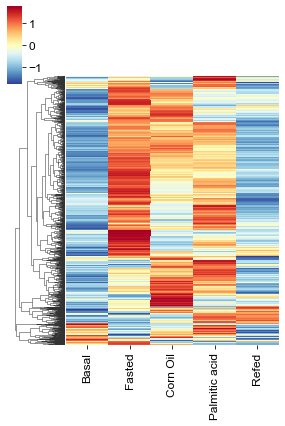

In [6]:
## Heatmap with all data

sns.clustermap(data[['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed']], 
               z_score=0, cmap='RdYlBu_r', col_cluster=False, figsize=(4,6), center=0, yticklabels=False)

plt.savefig('./heatmap.png', dpi=300)

In [7]:
# Selection of significant hits
_, data['adj_p'] = fdrcorrection(data['aov_p'])
hits = data[data['adj_p'] < 0.05]

print('number of hit:', hits.shape[0])

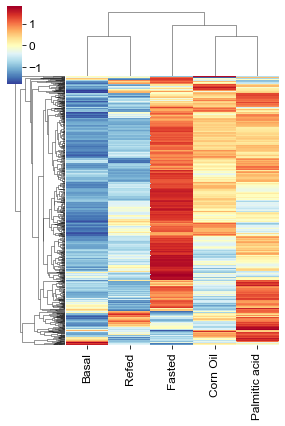

In [10]:
## Heatmap with only significant hits

g = sns.clustermap(hits[['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed']],
               z_score=0, cmap='RdYlBu_r', col_cluster=True, figsize=(4,6), center=0, yticklabels=False)

plt.savefig('./heatmap_hits.png', dpi=300)

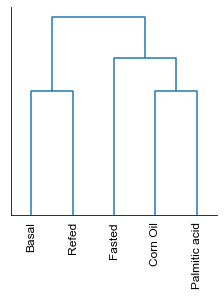

In [11]:
# Clustering of groups

fig, ax = plt.subplots(figsize=(3, 4), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

col_den = dendrogram(g.dendrogram_col.linkage, color_threshold=2.5, labels=['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed'], leaf_rotation='vertical')

plt.yticks([])
plt.savefig('./group_dendrogram.pdf')
plt.savefig('./group_dendrogram.png', dpi=300)

plt.show()

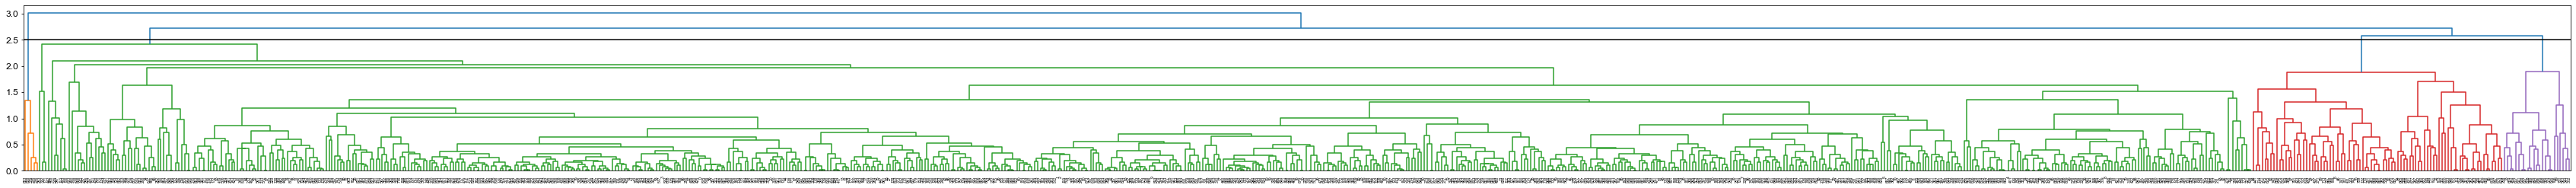

In [12]:
# Clustering on phosphosite levels

plt.figure(figsize=(60,4))
den = dendrogram(g.dendrogram_row.linkage, color_threshold=2.5, labels=g.dendrogram_row.reordered_ind)
plt.axhline(y=2.5, c='k')
plt.savefig('./dendrogram.pdf')
plt.show()

In [15]:
ordered_leave_colors = [den['leaves_color_list'][i] for i in np.argsort(g.dendrogram_row.reordered_ind)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  """


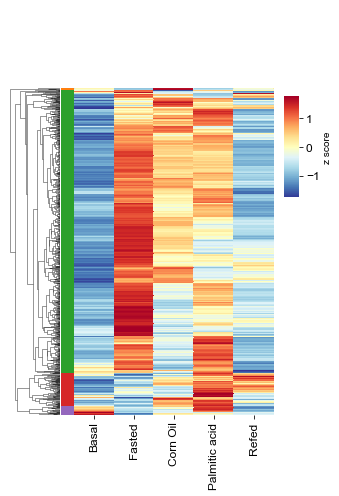

In [16]:
sns.clustermap(hits[['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed']], 
               z_score=0, cmap='RdYlBu_r', col_cluster=False, figsize=(4,7), center=0, vmin=-1.75, vmax=1.75, yticklabels=False, 
              row_colors=ordered_leave_colors, cbar_pos=(1, .6, .05, .2), cbar_kws={'label':'z score'}, colors_ratio=0.05, dendrogram_ratio=0.2)

plt.tight_layout()

plt.savefig('./heatmap_hits.png', dpi=300)
plt.savefig('./heatmap_hits.pdf')

## Analysis: focus on Cluster2 (green)

In [17]:
# Extract cluster members

prot_cluster_index = labels[np.where(colors == "C2")]
prot_cluster = hits[hits.index.isin(prot_cluster_index)]

In [18]:
len(prot_cluster_index)

750

In [19]:
# z score normalization of phosphosites

for prot in prot_cluster.index:
    
    µ = np.mean(prot_cluster.loc[prot, ['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed']])
    sd = np.std(prot_cluster.loc[prot, ['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed']])
    
    prot_cluster.loc[prot, 'Basal_z'] =  (prot_cluster.loc[prot, 'Basal'] - µ) / sd
    prot_cluster.loc[prot, 'Fasted_z'] =  (prot_cluster.loc[prot, 'Fasted'] - µ) / sd
    prot_cluster.loc[prot, 'Corn Oil_z'] =  (prot_cluster.loc[prot, 'Corn Oil'] - µ) / sd
    prot_cluster.loc[prot, 'Palmitic acid_z'] =  (prot_cluster.loc[prot, 'Palmitic acid'] - µ) / sd
    prot_cluster.loc[prot, 'Refed_z'] =  (prot_cluster.loc[prot, 'Refed'] - µ) / sd
                

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [21]:
green_cluster_to_plot = pd.melt(prot_cluster, id_vars='Protein Name', 
                                value_vars=['Basal_z', 'Fasted_z', 'Corn Oil_z', 'Palmitic acid_z', 'Refed_z'])

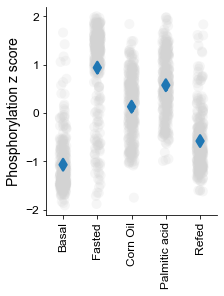

In [22]:
fig, ax = plt.subplots(figsize=(3, 4), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.stripplot(data=green_cluster_to_plot, x='variable', y='value', color='lightgray', size=10, alpha=.2, edgecolor='k', zorder=1)
sns.pointplot(data=green_cluster_to_plot, x='variable', y='value', join=False, markers='d', scale=1.2)

plt.ylabel('Phosphorylation z score', fontdict={'size': 14})
plt.yticks([-2, -1, 0, 1, 2])


plt.xlabel('')
plt.xticks([0, 1, 2, 3, 4], ['Basal', 'Fasted', 'Corn Oil', 'Palmitic acid', 'Refed'], rotation="vertical")

plt.savefig('./prot_cluster.png', dpi=300)
plt.savefig('./prot_cluster.pdf')

plt.show()

# iGPS analysis

### Get phosphopeptide sequences
load peptide info to get the phoshopeptide sequences to perform iGPS analysis

In [23]:
peptides = pd.read_excel('./Simplified iGPS analysis.xlsx')

In [24]:
for pep in peptides.index:
    
    peptides.loc[pep, 'Concatenate'] = '{name} {site}'.format(name=peptides.loc[pep, 'Protein Name'], site=peptides.loc[pep, 'Phospho site'])

In [25]:
#Copy phophopeptides to clipboard to paste in iGPS

peptides[peptides['Concatenate'].isin(prot_cluster.Concatenate)]['With "p"'].to_clipboard(index=False)

## Analyse iGPS results
selected peptides were submitted to iGPS and data were exported in an excel sheet

In [13]:
igps = pd.read_excel('./Proteomic_igps_green_cluster.xlsx')

In [17]:
subfamily_score = []

kinases, counts = np.unique(igps['subfamily'], return_counts=True)

for kin, c in zip(kinases, counts):
    
    res = dict()
    res['Subfamily'] = kin
    res['Count'] = c
    res['Score'] = np.sum(igps[igps['subfamily'] == kin]['Score'])
    
    subfamily_score.append(res)

In [18]:
kin_subfamilies = pd.DataFrame(subfamily_score)
kin_subfamilies['normalized'] = kin_subfamilies['Score'] / kin_subfamilies['Count']

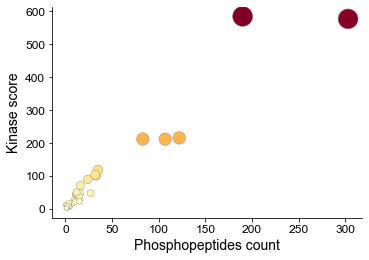

In [19]:
fig, ax = plt.subplots(figsize=(5, 3.5), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.scatterplot(data=kin_subfamilies, x='Count',y='Score', size='Score', sizes=(20, 400), hue='Score', palette='YlOrRd', 
                edgecolor='gray')
plt.legend()

ax.get_legend().remove()

plt.ylabel('Kinase score', fontdict={'size':14})

#plt.ylim(0, 55)

plt.xlabel('Phosphopeptides count', fontdict={'size':14})
#plt.xlim(0, 20)

plt.savefig('./igps_prot_cluster_subfamilies.png', dpi=300)

plt.show()

In [21]:
# Add subfamilies data to dataset

with pd.ExcelWriter('./Proteomic_igps_green_cluster.xlsx', engine='openpyxl', mode='a') as writer:
    
    kin_subfamilies.to_excel(writer, sheet_name='subfamily_scores') 